In [1]:
# load necessary libraries
import numpy as np
from scipy import ndimage
from scipy import misc
from scipy import stats

import matplotlib.pyplot as plt

from skimage import filters as skimfilt
import csv
import json
import random

import sys, os
import pandas as pd
import pickle
from datetime import datetime
import glob

from readImages import *
from imageModifiers import *
from readDataFiles import *
from projEdgeBreaks import *
from gaussBreaks import *
from saveImages import *
from plottingFuncs import *

# change pandas parameter
pd.options.mode.chained_assignment = None
# change plot size
mpl.rcParams["figure.figsize"] = (15, 15)

## Specify file and folder locations

In [2]:
subjFile = "data/decoding-the-civil-war-subjects-9-29-17.csv"
clFile = 'data/letter-slope-classifications_10nov2017.csv'
savefile = "accuracy.pkl"

consensusFolder = "C:/Users/danny/Repos/text_segmentation/consensus/consensus/"
# consensusFile = consensusFolder + "decoding-the-civil-war-consensus-linewise_{mss_label}.csv"
consensusCsvFiles = glob.glob('{}/*.csv'.format(consensusFolder))
consensusCsvFiles = [i for i in consensusCsvFiles if "linewise" in i]

### Read data files

In [3]:
def matchLines(lb, actuallb, matchlim = 30):
    matches = []
    for i in range(len(lb)):
        closest = np.argmin(np.abs(np.subtract(lb[i], actuallb)))
        if np.abs(lb[i] - actuallb[closest]) < matchlim:
            matches.append(closest)
        else:
            matches.append(-1)
    return matches


nuOpt = np.arange(0.5, 6.5, 0.5) # 0.5:6.5
biOpt = list(range(1, 10)) # 1:10

def wordBreaks(grey, lb, matches, linesForTele, nuOpt=nuOpt, biOpt=biOpt):
    accurL = []

    for i in range(1, len(lb)):
        print(i, end=" ")
        if matches[i] == -1:
            continue
        chunk = grey[lb[i-1]:lb[i],]
        rw = linesForTele.loc[matches[i],"consensus_text"]
        # remove leading and trailing "
        if rw[0] == '"':
            rw = rw[1:]
        if rw[-1] == '"':
            rw = rw[:-1]
        nr = len(rw.split(" "))
        for nu in nuOpt:
            for bi in biOpt:
                br = gaussBreaks(chunk, nu=nu, biThresh=bi, shear=0, fix=0)
                accurL.append({"i":i, "nu":nu, "bi":bi, "nr":nr, "br":br})
    return pd.DataFrame(accurL)

In [26]:
def wordBreaks2(grey, lb, matches):
    wbreaks = {}
    wbreaks[0] = []
    for i in range(1, len(lb)):
        print(i, end=" ")
        if matches[i] == -1:
            wbreaks[i] = [0, 100]
            continue
        chunk = grey[lb[i-1]:lb[i],]
        br = gaussBreaks(chunk, nu=3.5, biThresh=2, shear=0, fix=0)
        wbreaks[i] = br
    return wbreaks

wb = wordBreaks2(grey, lb, matches)


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

IndexError: list index out of range

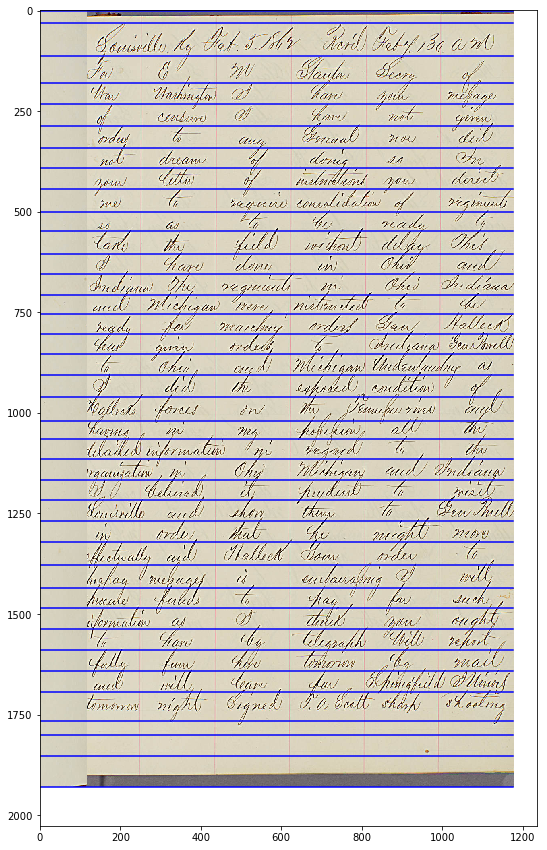

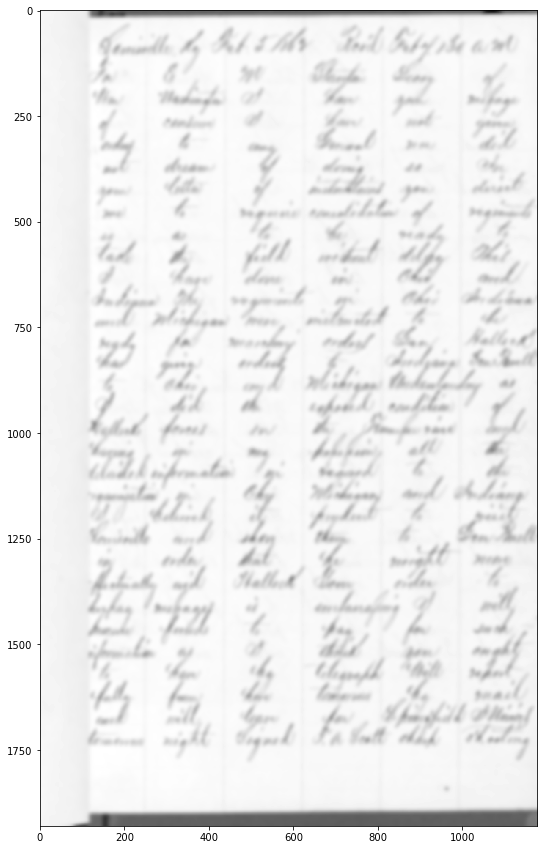

In [5]:
plotBoxes(let2['soft'], lb=lb)#, wb=wb)
plt.imshow(greySm, cmap='gray')
plt.show()

In [40]:
idAndUrl.loc[im, "url_cons"]

'https://panoptes-uploads.zooniverse.org/production/subject_location/088bb5aa-7265-4246-a784-59d1ad1793ee.jpeg'

In [4]:
# subject file
subj = readSubjFile(subjFile)
# classification export
clExp = readSlopeClassification(clFile)

for consensusFile in consensusCsvFiles:
    ##############################################################################################
    # Read data files
    # consensus file (by line)
    cons = readConsensusFile(consensusFile)
    # combine data files
    idAndUrl, telegrams = mergeSubjAndCons(subj, cons, clExp)
    
    ##############################################################################################
    # collect the data for the wordbreaks
    data = {}

    for im in list(idAndUrl.index):
        hdl_id = idAndUrl.loc[im, "hdl_id"]
        data[hdl_id] = {}
        print(hdl_id)

        data[hdl_id]["url"] = idAndUrl.loc[im, "url_cons"]
        linesForTele = telegrams.loc[telegrams["hdl_id"] == hdl_id]
        linesForTele.loc[:,"y1"] = [eval(l)[0] for l in linesForTele.loc[:,"y_loc"]]


        # read in and do all pre-processing #################################
        let, grey = readImg(idAndUrl.loc[im, "url_cons"])
        grey, let2, thresh_inf = removeEdges(grey, let, 35.0)
        grey = grey['soft']#thresh_inf['greyWhitened']['soft']
        greySm = smoothImg(grey, sigma=5.0)
#         greyBi = binarizeImg(grey, biThresh=skimfilt.threshold_otsu)
#         greyBiSm = smoothImg(greyBi, sigma=5.0)


        # get linebreaks ####################################################
        matchlim = 30
        lb = projBreaks(greySm, "y")
        lb = filterBreaks(lb, matchlim)
        data[hdl_id]["lb"] = lb

        break
        # get matching lines with actual lines ##############################
        actuallb = linesForTele.loc[:, "y1"]
        matches = matchLines(lb, actuallb)
        data[hdl_id]["matches"] = matches

        # get wordbreaks ####################################################
        accur = wordBreaks(grey, lb, matches, linesForTele)
        data[hdl_id]["segment"] = accur
        print()
        
        # save object
#         with open(savefile, "wb") as f:
#             pickle.dump(data, f)
        break
    break

mssEC_02_007
